In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage import transform
import os

#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True) 

2023-03-29 19:53:45.095214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


If you are running this tutorial locally such as in vsCode, download the dataset in the link below, unzip, and save in a new local folder called /asl-alphabet. 

### Larger dataset
https://www.kaggle.com/datasets/grassknoted/asl-alphabet

### Smaller dataset
https://www.kaggle.com/datasets/danrasband/asl-alphabet-test

If running this tutorial google colab, follow this link (https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) to download an api key kaggle.json file from your kaggle acount and uncomment and the following code to download the dataset directly from kaggle.

# Set Datasets Using Dataset From Directory Class

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [2]:
# Create class names
class_names = ["A", "B", "C", "D", "E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","del","nothing","space"]


train_dir = "asl_alphabet/asl_alphabet_train/asl_alphabet_train"
validation_dir = "asl_alphabet/asl_alphabet_test/asl_alphabet_test"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# set the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
# set the testing dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 87001 files belonging to 29 classes.
Found 28 files belonging to 28 classes.


2023-03-29 19:53:48.145618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 19:53:48.145782: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Plot Samples From the first batch of training data

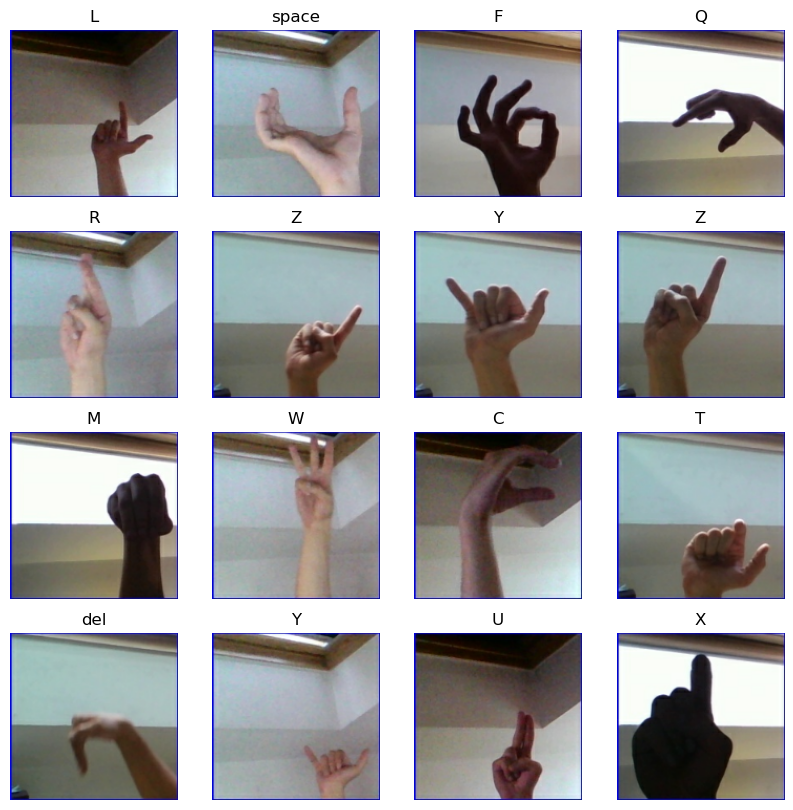

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Split DataSet Into Train-Val-Test

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 1
Number of test batches: 0


# Improve Runtime

https://www.tensorflow.org/guide/data_performance

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Define data augmentation steps
 ## placeholeder for now

In [6]:
data_augmentation = tf.keras.Sequential([
  # tf.keras.layers.RandomFlip('horizontal'),
  # tf.keras.layers.RandomRotation(0.2),
])

# 2. Input Pre-processing Steps
## Will be called later (check this fits our model)

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## 3. One hot encoding

# 6. Transfer Learning

## Load Model

In [8]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


## View Model Summary

In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


6.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)

6.2 Freeze the layers (i.e., make them non-trainable) of your pretrained model

In [10]:
base_model.trainable = False

In [11]:
# model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


## Build model by chaining preprocessing steps

In [14]:
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Set optimizer, learing rate loss, etc...

In [15]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [17]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1/1 [==============================] - 1s 756ms/step - loss: 1.6093e-06 - accuracy: 0.0357
initial loss: 0.00
initial accuracy: 0.04


# Training with test dataset so id doesnt take long
## need to change

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
2719/2719 [==============================] - 508s 187ms/step - loss: 1.6689e-06 - accuracy: 0.0353 - val_loss: 1.6093e-06 - val_accuracy: 0.0357
Epoch 2/10
2719/2719 [==============================] - 505s 186ms/step - loss: 1.6689e-06 - accuracy: 0.0350 - val_loss: 1.6093e-06 - val_accuracy: 0.0357
Epoch 3/10
 817/2719 [========>.....................] - ETA: 6:10 - loss: 1.6646e-06 - accuracy: 0.0355

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()